In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from sklearn.model_selection import train_test_split
import re
import fasttext


In [5]:
df = pd.read_csv('data/Fake_Real_Data.csv')

In [6]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip cc.en.300.bin.gz

--2025-11-06 13:34:52--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.41.33, 99.84.41.80, 99.84.41.79, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.41.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G   216MB/s    in 24s     

2025-11-06 13:35:16 (176 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [9]:
# Load pretrained FastText binary model
ft_model = fasttext.load_model("cc.en.300.bin")


In [10]:
def text_processing(text):
    text = re.sub(r'[^\w\s\']',' ', text)
    text = re.sub(r'[ \n]+', ' ', text)
    if not text or not isinstance(text, str):
        return np.zeros(300)
    return ft_model.get_sentence_vector(text.lower().strip())



In [11]:
df['text_vector'] = df['Text'].apply(lambda x: text_processing(x))

In [55]:
class_names = {'Real': 0, 'Fake': 1}

X = np.vstack(df['text_vector'].values)
y = df['label'].map(class_names).values

In [56]:
y = np.array(y).reshape(-1)

type(y[0])

numpy.int64

In [57]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
y = np.reshape(y, (y.shape[0], 1, 1))

In [58]:
X.shape, y.shape

((9900, 300, 1), (9900, 1, 1))

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [65]:
y_test = np.array(y_test).reshape(-1)
y_train = np.array(y_train).reshape(-1)
type(y_test[1])

numpy.int64

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


In [72]:
model_lstm = Sequential([
    Input(shape=(300,1)),
    LSTM(128, return_sequences=False),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [73]:
model_lstm.fit(X_train,y_train,batch_size=32,epochs=50)

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.8033 - loss: 0.4319
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8859 - loss: 0.2914
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9179 - loss: 0.2214
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9245 - loss: 0.1949
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9308 - loss: 0.1895
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6596 - loss: 0.7237
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8029 - loss: 0.4375
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.8248 - loss: 0.4017
Epoch 9/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8717 - loss: 0.3146
Epoch 10/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8896 - loss: 0.2821
Epoch 11/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9220 - loss: 0.2100
Epoch 12/50
248/248 ━━━━━━━━━━━━━━━━━━━

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9725    0.9851    0.9788      1007
           1     0.9844    0.9712    0.9778       973

    accuracy                         0.9783      1980
   macro avg     0.9785    0.9782    0.9783      1980
weighted avg     0.9784    0.9783    0.9783      1980



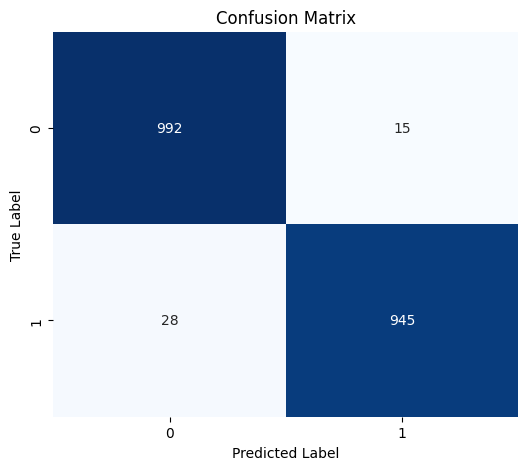

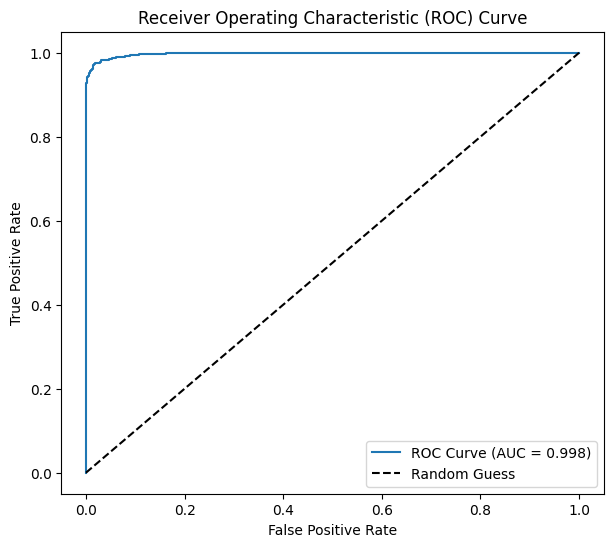

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# --- Get predictions ---
# Predict probabilities
y_pred_prob = model_lstm.predict(X_test)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# --- Classification Report ---
print("\n Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


In [ ]:
model_lstm.save("fake_news_lstm_model.keras")